# 2021-10-26 Timeline stats

Beginnings of statistical analysis based on the timeline stats of users, NOT the clustering word data yet. Also should I get the follows?

In [1]:
import os
import pprint
import tqdm
import json
import glob
import jsonlines
import pandas as pd
import pickle
import numpy as np
import matplotlib.pyplot as plt
import sys
from collections import Counter
import datetime
import h5py
from typing import NamedTuple
import re
import statsmodels.api as sm
from operator import attrgetter
import statsmodels.formula.api as smf

In [2]:
#load in search hashtags
with open('../references/search_hashtags.txt', 'r') as f:
    search_hashtags = f.readlines()
    search_hashtags = [i.replace('\n', '') for i in search_hashtags]
    search_hashtags = [i.replace('#', '') for i in search_hashtags]
    search_hashtags = [i.lower() for i in search_hashtags]
    search_hashtags.remove('وأناكمان')

## Parameters

In [3]:
group_num = 1

## Load in data and basic preprocessing

In [4]:
interactions_hdf5_file = '/home/hubert/DPhil_Studies/2021-04_Study_A_Diffusion/data/03_processed/interactions.hdf5'

df = pd.read_hdf(interactions_hdf5_file,f'interactions_group_{group_num}')

In [5]:
def convert_in_reply_to(x):
    if x:
        return x[0]
    else:
        return None

df['in_reply_to'] = df['in_reply_to'].apply(convert_in_reply_to)

In [6]:
# remove self replies

df = df[df['author_id']!=df['in_reply_to']]
# generate counts of internal mentions/quotes/replies

df['internal'] = df['in_reply_to'].isin(df['author_id'])
# df['internal_mentions'] = df['mentions'].apply(lambda x: any(df['author_id'].isin(x)))

# df['internal_replies'] = df['replies'].apply(lambda x: any(df['tweet_id'].isin(x)))
# df['internal_quotes'] = df['quotes'].apply(lambda x: any(df['tweet_id'].isin(x)))

In [7]:
internal = df['internal'].sum()
print(f'Internal replies (not self replies): {internal}')
print(f'Total df length: {len(df)}')

Internal replies (not self replies): 275164
Total df length: 7939920


In [8]:
user_interaction_counts = df[['author_id','tweet_id']].groupby('author_id').count()

user_interaction_counts.describe()

,tweet_id
count,4216.000000
mean,1883.282732
std,2837.788446
min,1.000000
25%,148.750000
50%,763.000000
75%,2498.250000
max,26390.000000


### Multiple participation in protest networks
Another preprocessing/data description step: How many how many users participate in more than one protest network in this time period **in their interactions**?

In [9]:
for hashtag in search_hashtags:
    df['vocab:#'+hashtag] = df['contains_hashtags'].apply(lambda x: any(hashtag.lower() == item.lower() for item in x))

#columns with vocab: in them
vocab_colnames = [i for i in list(df.columns) if 'vocab:#' in i]

df['network_participation'] = df[vocab_colnames].sum(axis=1)
df['multiple_participation'] = df['network_participation']>1

df_participate = df[['author_id','multiple_participation']].groupby('author_id').sum()

print(df_participate.describe())

above_one = (df_participate >= 1).sum()
print(f'{above_one} users participate in more than one protest network in interactions')

       multiple_participation
count             4216.000000
mean                 3.486243
std                 21.048806
min                  0.000000
25%                  0.000000
50%                  0.000000
75%                  1.000000
max                855.000000
multiple_participation    1302
dtype: int64 users participate in more than one protest network in interactions


In [10]:
# # Generate simple counter of users either mentioned or replied to inside or outside the current author list

# users_actually_interacted_with = Counter()

# for row in df.itertuples():
#     try:
#         for mentioned in row.mentions:
#             users_actually_interacted_with[mentioned] += 1
#         users_actually_interacted_with[row.in_reply_to] += 1
#     except:
#         print(row)
#         break

# users_actually_interacted_with.most_common()[:10]

To match on activity, let's collect their base timelines and see how much they tweeted

To determine the output variables from this continuous time scope we need the peaks again.

In [11]:
def unit_conv(val):
    return datetime.datetime.strptime('2017-10-16', '%Y-%m-%d') + datetime.timedelta(days=int(val))

#obtain peak times again
with h5py.File('/home/hubert/DPhil_Studies/2021-04_Study_A_Diffusion/data/02_intermediate/FAS_peak_analysis.hdf5', 'r') as f:
    FAS_peaks = f['peak_detections']

    most_prominent_peaks = {}
    for name, h5obj in FAS_peaks.items():
        if len(h5obj['prominences']) == 0:
            continue
        max_prominence = np.argmax(h5obj['prominences'])
        most_prominent_peaks[name] = unit_conv(h5obj['peak_locations'][max_prominence])

Start creating the df needed for stats. Each user needs to have
* normal activity before and after
* hashtagged activity before and after
* number of interactions with (each) protest network
* protest networks participated in (organise by pairs?)
* before and after peaks of each network participation


In [12]:
# get list of hashtags in search ones
df['author_total_hashtags'] = df['contains_hashtags'].apply(lambda x: [i for i in x if i.lower() in search_hashtags])

In [13]:
# get peaks for each hashtag into the pandas
for ht in search_hashtags:
    if ht != 'وأناكمان':
        with_sym_ht = f'#{ht}'
        df[f'peak_{ht}'] = df['created_at'].apply(lambda x: x > most_prominent_peaks[ht].date())

## Vocabulary Input: Python Clustering Eval Results

Now for vocabulary input. First load in the relevant files

In [14]:
# load bsc model, features names, csr, and user ('document') ids

bsc_model_list = glob.glob(os.path.join('/home/hubert/DPhil_Studies/2021-04_Study_A_Diffusion/data/05_model_output/01_group','*.obj'))

bsc_eval_hdf5 = '/home/hubert/DPhil_Studies/2021-04_Study_A_Diffusion/data/05_model_output/bispec_cluster_eval.hdf5'

ngram_range = '34'
min_user = 100

feature_mapping_file = f'/home/hubert/DPhil_Studies/2021-04_Study_A_Diffusion/data/02_intermediate/0{group_num}_group/mapping_ngram_{ngram_range}.obj'

csr_file = f'/home/hubert/DPhil_Studies/2021-04_Study_A_Diffusion/data/02_intermediate/0{group_num}_group/user_count_mat_ngram_{ngram_range}.obj'

Assess eval

In [15]:
class single_cluster(NamedTuple):
    n_clusters: int
    n_invalid: int
    total_ncut: float
    norm_ncut: float

cluster_evals = []
with h5py.File(bsc_eval_hdf5, 'r') as f:
    x = f[f'group_{group_num}'][f'ngram_{ngram_range}'][f'min_{min_user}']
    for key, h5_data in x.items():
        h5_data = h5_data[:,1]
        total_ncut = np.sum([i for i in h5_data if i > 0])
        n_invalid = np.sum([i < 0 for i in h5_data])
        cluster_evals.append(single_cluster(
            n_clusters=int(key),
            n_invalid=n_invalid,
            total_ncut=total_ncut,
            norm_ncut=total_ncut/int(key)
        ))

Visualise cluster evaluation

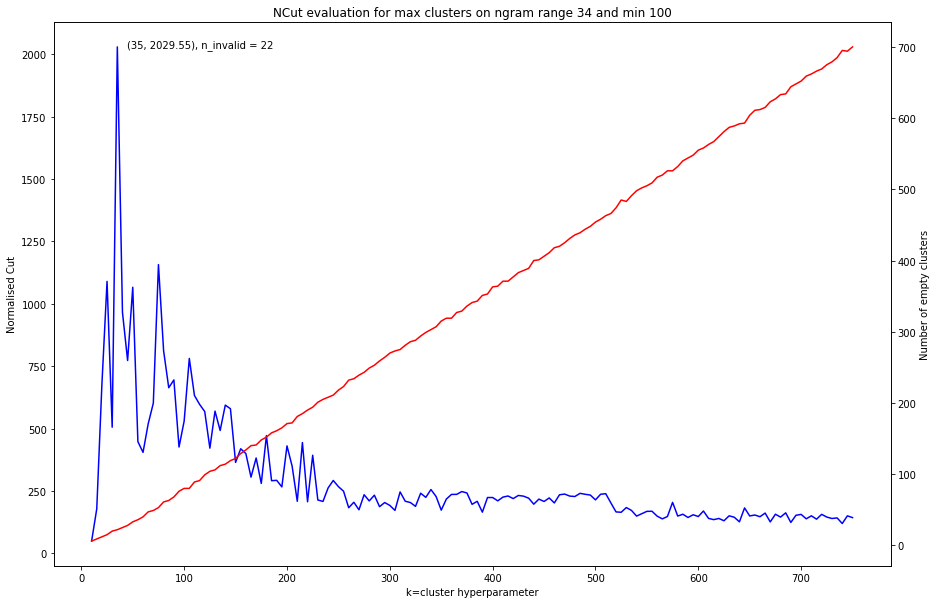

In [16]:
cluster_evals = sorted(cluster_evals, key=lambda x: x.n_clusters)

x_data = [i.n_clusters for i in cluster_evals]
y_data = [i.norm_ncut for i in cluster_evals]

y_invalid = [i.n_invalid for i in cluster_evals]

f, ax1 = plt.subplots(figsize=(15,10))
ax1.plot(x_data, y_data, color = 'blue')
ax2 = ax1.twinx()
ax2.plot(x_data, y_invalid, color='red')
ax1.set_title(f'NCut evaluation for max clusters on ngram range {ngram_range} and min {min_user}')
ax1.set_xlabel('k=cluster hyperparameter')
ax1.set_ylabel('Normalised Cut')
ax2.set_ylabel('Number of empty clusters')
best_cluster = sorted(cluster_evals, key=attrgetter('norm_ncut'), reverse=True)[0]
ax1.annotate(
    f'({best_cluster.n_clusters}, {best_cluster.norm_ncut:.2f}), n_invalid = {best_cluster.n_invalid}',
    (best_cluster.n_clusters, best_cluster.norm_ncut),
    textcoords = 'offset points',
    xytext = (10,0),
    ha = 'left'
);

selected_model = best_cluster.n_clusters

Load in selected model data, csr, etc.

In [17]:
def model_params_from_file(filename):
    return re.split('[_.]',filename)

selected_model_file = [i for i in bsc_model_list if int(model_params_from_file(i)[-6])==selected_model and model_params_from_file(i)[-4] == ngram_range][0]

with open(selected_model_file, 'rb') as f:
    model = pickle.load(f)

# open mapping also get relevent features names and user ids
with open(feature_mapping_file, 'rb') as f:
    feature_names = pickle.load(f)

# also load in csr
with open(csr_file,'rb') as f:
    csr = pickle.load(f)

# get also the userlist that was used to generate this for 'document' names
user_doc_ids = sorted(glob.glob(os.path.join(f'/home/hubert/DPhil_Studies/2021-04_Study_A_Diffusion/data/01_raw/0{group_num}_group/','timeline*.jsonl')))
user_doc_ids = [re.split('[_.]',i)[-2] for i in user_doc_ids]
assert len(user_doc_ids)>0

In [18]:
# function to extract top phrases from cluster
def extract_cluster_words(feature_names, user_ids, csr, model, cluster_num, top_n = 20):
    row_ind, col_ind = model.get_indices(cluster_num)

    csr_cluster = csr[row_ind][:,col_ind]
    feature_csr_sums = csr_cluster.sum(axis=0)
    top_features = np.argsort(feature_csr_sums)
    top_features = np.asarray(top_features).flatten()
    return [feature_names[i] for i in top_features[-1:-top_n:-1]]

cluster_words_dict = {}

for i in range(best_cluster.n_clusters):

    top_n = 50

    cluster_words_dict[i] = extract_cluster_words(
        feature_names,
        user_doc_ids,
        csr,
        model,
        i,
        top_n = top_n
    )

    if len(cluster_words_dict[i]) < top_n-1:
        cluster_words_dict[i] = cluster_words_dict[i] + [None]*(top_n-1-len(cluster_words_dict[i]))

In [19]:
df_cluster_words = pd.DataFrame.from_dict(cluster_words_dict)

## Finally, a statistical model

### Activity

In [ ]:
# save progress
combined_analysis_save_file = '/home/hubert/DPhil_Studies/2021-04_Study_A_Diffusion/data/06_reporting/combined_analysis.hdf5'

if os.path.isfile(combined_analysis_save_file):
    with h5py.File(combined_analysis_save_file, 'r') as f:
        check = f'group_{group_num}' in f.keys()
    if check:
        df = pd.read_hdf(combined_analysis_save_file, f'group_{group_num}')

In [20]:
# FAS analysis file
FAS_peak_analysis_file = '/home/hubert/DPhil_Studies/2021-04_Study_A_Diffusion/data/02_intermediate/FAS_peak_analysis.hdf5'

class daterange(NamedTuple):
    start: str
    end: str

def daterange_from_group_num(group_num):
    with h5py.File(FAS_peak_analysis_file, 'r') as f:
        x = f['segments']['selected_ranges'][0]
        res = daterange(
            start = x[0].decode(),
            end = x[1].decode()
        )
    return res

# insert activity of users
def date_to_array_index(date, daterange):
    return (date - datetime.datetime.strptime(daterange.start, '%Y-%m-%d').date()).days

activity_file = '/home/hubert/DPhil_Studies/2021-04_Study_A_Diffusion/data/03_processed/activity_counts.hdf5'

with h5py.File(activity_file, 'r') as f:
    # print(f.keys())
    x = f['group_1']['1005675566']['hashtagged'].attrs['feature_order']
    ht_row_mapping = x.split(';')

group_daterange = daterange_from_group_num(group_num)

In [21]:
# do by hashtag. group by users and then whether it was before peak
class stats_df_tuple(NamedTuple):
    ht_target: str
    data: pd.DataFrame

def retrieve_activity_user(row, daterange=None, activity_file = None, activity='hashtagged', hashtag=None, group_num = 1, ht_row_mapping = None):

    if activity == 'hashtagged':
        if row[f'peak_{hashtag}']:
            after = date_to_array_index(row['created_at'], daterange)
            # get ht row index
            assert hashtag in ht_row_mapping
            ht_index = ht_row_mapping.index(hashtag)
            # print(f'group_{group_num}', row['author_id'], after)
            result = activity_file[f'group_{group_num}'][row['author_id']][activity][ht_index,after:]
        else:
            up_to = date_to_array_index(row['created_at'], daterange)
            # get ht row index
            assert hashtag in ht_row_mapping
            ht_index = ht_row_mapping.index(hashtag)
            # print(f'group_{group_num}', row['author_id'], ht_index, up_to)
            result = activity_file[f'group_{group_num}'][row['author_id']][activity][ht_index,:up_to]
    else:
        if row[f'peak_{hashtag}']:
            after = date_to_array_index(row['created_at'], daterange)
            # print(f'group_{group_num}', row['author_id'], after)
            result = activity_file[f'group_{group_num}'][row['author_id']][activity][after:]
        else:
            up_to = date_to_array_index(row['created_at'], daterange)
            # print(f'group_{group_num}', row['author_id'], up_to)
            result = activity_file[f'group_{group_num}'][row['author_id']][activity][:up_to]

    if len(result)>0:
        s = np.sum(result)
        # print(s)
        return s
    else:
        return 0

res = []
with h5py.File(activity_file, 'r') as f:
    for ht_target in search_hashtags:
        # print(ht_target)
        # take only the rows for before the peak. Group by 
        filtered =  df[~df[f'peak_{ht_target}'] & df[f'vocab:#{ht_target}']]
        num_interacts = filtered.groupby(['author_id']).agg(int_pre_peak = pd.NamedAgg(column="tweet_id", aggfunc="count"))
        act_pre_peak = filtered.sort_values('created_at', ascending=False).groupby('author_id').agg(lambda x: x.iloc[0]).reset_index()

        if act_pre_peak.empty:
            num_interacts['act_pre_peak'] = 0
            num_interacts['norm_act_pre_peak'] = 0
        else:
            act_pre_peak['act_pre_peak'] = act_pre_peak.apply(
                retrieve_activity_user,
                daterange=group_daterange,
                activity_file=f,
                hashtag=ht_target,
                group_num=group_num,
                ht_row_mapping = ht_row_mapping,
                axis=1
            )


            # add normal activity too
            act_pre_peak['norm_act_pre_peak'] = act_pre_peak.apply(
                retrieve_activity_user,
                daterange=group_daterange,
                activity_file=f,
                activity='normal',
                hashtag=ht_target,
                group_num=group_num,
                axis=1
            )

            num_interacts = num_interacts.join(act_pre_peak[['author_id','act_pre_peak', 'norm_act_pre_peak']].set_index('author_id'))

        act_post_peak = df[df[f'peak_{ht_target}'] & df[f'vocab:#{ht_target}']]
        act_post_peak = act_post_peak.sort_values('created_at', ascending=False).groupby('author_id').agg(lambda x: x.iloc[0]).reset_index()

        if act_post_peak.empty:
            num_interacts['act_post_peak'] = 0
        else:
            act_post_peak['act_post_peak'] = act_post_peak.apply(
                retrieve_activity_user,
                daterange=group_daterange,
                activity_file=f,
                hashtag=ht_target,
                group_num=group_num,
                ht_row_mapping = ht_row_mapping,
                axis=1
            )
            temp = act_post_peak[['author_id','act_post_peak']].set_index('author_id')

            num_interacts = num_interacts.join(temp)
        num_interacts = num_interacts.reset_index().fillna(0)
        num_interacts['ht'] = ht_target
        res.append(stats_df_tuple(ht_target=ht_target, data=num_interacts))

In [22]:
stats_df = pd.concat([i.data for i in res], axis=0)

In [23]:
stats_df

,author_id,int_pre_peak,act_pre_peak,norm_act_pre_peak,act_post_peak,ht
0,10118982,1,9.0,941,1.0,metoo
1,1013557603,38,77.0,2048,0.0,metoo
2,1023568159,33,43.0,42,8.0,metoo
3,102496469,2,0.0,0,0.0,metoo
4,1025741330,12,23.0,1630,1.0,metoo
...,...,...,...,...,...,...
483,96825619,2,6.0,43,4.0,timesup
484,97423151,1,0.0,267,0.0,timesup
485,988406744,2,9.0,51,0.0,timesup
486,989210214,2,17.0,177,2.0,timesup


### Incorporate Vocab

In [1]:
# first attempt 2021-12-01: Simply assign cluster assignment as categorical variable

# get rows that correspond to the users
author_model_indices = np.searchsorted(user_doc_ids,stats_df['author_id'])
cluster_labels = model.row_labels_[author_model_indices]

stats_df['cluster'] = cluster_labels
stats_df['cluster'] = stats_df['cluster'].astype('category')

NameError: name 'np' is not defined

### Process logarithmic

In [25]:
stats_df['log_act_post_peak'] = np.log(stats_df['act_post_peak']+1)
stats_df['log_act_pre_peak'] = np.log(stats_df['act_pre_peak']+1)
stats_df['log_int_pre_peak'] = np.log(stats_df['int_pre_peak']+1)
stats_df['log_norm_act_pre_peak'] = np.log(stats_df['norm_act_pre_peak']+1)

In [26]:
stats_df

,author_id,int_pre_peak,act_pre_peak,norm_act_pre_peak,act_post_peak,ht,cluster,log_act_post_peak,log_act_pre_peak,log_int_pre_peak,log_norm_act_pre_peak
0,10118982,1,9.0,941,1.0,metoo,3,0.693147,2.302585,0.693147,6.848005
1,1013557603,38,77.0,2048,0.0,metoo,3,0.000000,4.356709,3.663562,7.625107
2,1023568159,33,43.0,42,8.0,metoo,32,2.197225,3.784190,3.526361,3.761200
3,102496469,2,0.0,0,0.0,metoo,3,0.000000,0.000000,1.098612,0.000000
4,1025741330,12,23.0,1630,1.0,metoo,3,0.693147,3.178054,2.564949,7.396949
...,...,...,...,...,...,...,...,...,...,...,...
483,96825619,2,6.0,43,4.0,timesup,3,1.609438,1.945910,1.098612,3.784190
484,97423151,1,0.0,267,0.0,timesup,3,0.000000,0.000000,0.693147,5.590987
485,988406744,2,9.0,51,0.0,timesup,3,0.000000,2.302585,1.098612,3.951244
486,989210214,2,17.0,177,2.0,timesup,3,1.098612,2.890372,1.098612,5.181784


### Stats model 1: No hashtag splitting, average across all diffusions

In [27]:
# do I want an intercept?
stats_model_1 = smf.ols('act_post_peak ~ act_pre_peak + int_pre_peak + + norm_act_pre_peak + cluster',
    data = stats_df
)
stats_result_1 = stats_model_1.fit()

In [28]:
stats_result_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          act_post_peak   R-squared:                       0.148
Model:                            OLS   Adj. R-squared:                  0.139
Method:                 Least Squares   F-statistic:                     17.09
Date:                Thu, 02 Dec 2021   Prob (F-statistic):           1.58e-81
Time:                        13:32:25   Log-Likelihood:                -14582.
No. Observations:                2993   AIC:                         2.923e+04
Df Residuals:                    2962   BIC:                         2.941e+04
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept            12.8428      6.263      2.051      0.040       0.563      25.123
cluster[T.1]        -17.9618     19.367     -0.927      0.354     -55.937      20.013
cluster[T.3]        -12.1210      6.269     -1.934      0.053     -24.413       0.171
cluster[T.4]        -14.7852     17.086     -0.865      0.387     -48.287      18.716
cluster[T.5]        -16.7710     23.432     -0.716      0.474     -62.716      29.174
cluster[T.6]        -31.0901     32.379     -0.960      0.337     -94.578      32.397
cluster[T.7]        -14.8902     32.377     -0.460      0.646     -78.373      48.593
cluster[T.8]        -12.6977     32.373     -0.392      0.695     -76.174      50.779
cluster[T.10]       -12.4989     23.309     -0.536      0.592     -58.203      33.205
cluster[T.11]       -13.3320      8.910     -1.496      0.135     -30.802       4.138
cluster[T.14]       -15.4733     23.311     -0.664      0.507     -61.181      30.234
cluster[T.15]       126.3290     11.441     11.042      0.000     103.896     148.763
cluster[T.16]       -14.4956      8.660     -1.674      0.094     -31.475       2.484
cluster[T.17]        -8.6190     11.408     -0.756      0.450     -30.987      13.749
cluster[T.18]       -12.8238     19.374     -0.662      0.508     -50.811      25.164
cluster[T.19]        -7.9675     32.366     -0.246      0.806     -71.430      55.495
cluster[T.20]        12.8282     32.406      0.396      0.692     -50.712      76.369
cluster[T.21]        29.8239     19.373      1.539      0.124      -8.162      67.809
cluster[T.22]        20.3077     32.435      0.626      0.531     -43.290      83.906
cluster[T.25]       -21.8467     23.310     -0.937      0.349     -67.552      23.859
cluster[T.26]        -9.4056     23.303     -0.404      0.687     -55.097      36.286
cluster[T.27]       -22.6030     12.845     -1.760      0.079     -47.789       2.583
cluster[T.28]       -12.8703     19.379     -0.664      0.507     -50.868      25.128
cluster[T.29]       -13.1304     13.534     -0.970      0.332     -39.668      13.407
cluster[T.31]       -15.2281     10.785     -1.412      0.158     -36.376       5.919
cluster[T.32]        11.0064     14.439      0.762      0.446     -17.306      39.319
cluster[T.33]        -2.0144     12.323     -0.163      0.870     -26.177      22.149
cluster[T.34]        -8.2768     19.449     -0.426      0.670     -46.411      29.857
act_pre_peak          0.0923      0.006     15.895      0.000       0.081       0.104
int_pre_peak         -0.1446      0.009    -15.497      0.000      -0.163      -0.126
norm_act_pre_peak -7.861e-05      0.000     -0.361      0.718      -0.001       0.000
==============================================================================
Omnibus:                     7932.629   Durbin-Watson:                   1.984
P

In [29]:
stats_df['act_post_peak'].describe()

count    2993.000000
mean        3.399599
std        34.227661
min         0.000000
25%         0.000000
50%         1.000000
75%         2.000000
max      1663.000000
Name: act_post_peak, dtype: float64

In [30]:
stats_df['int_pre_peak'].max()

12260

eval_env: 1


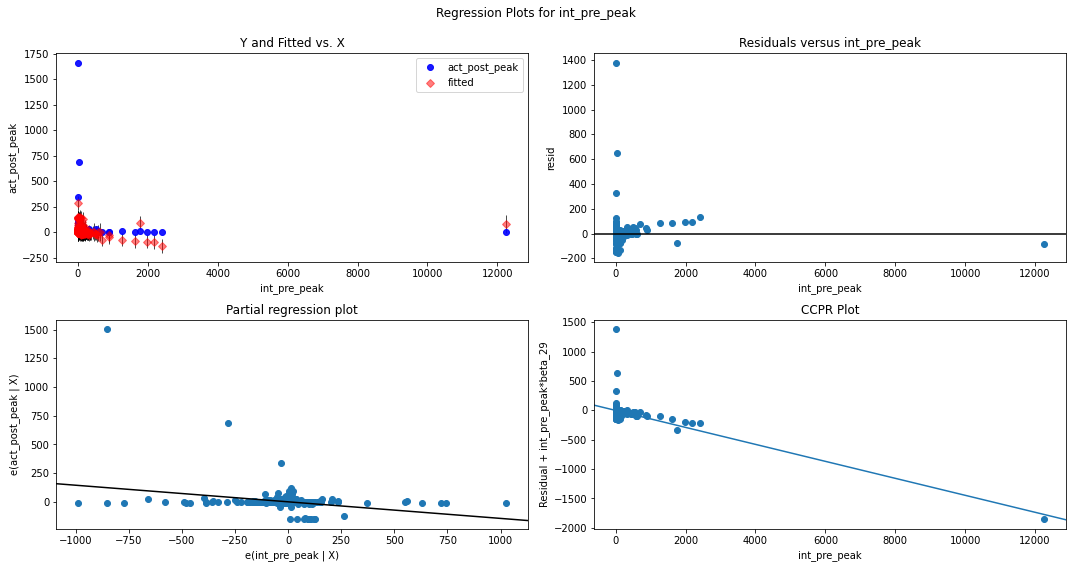

In [31]:
fig = plt.figure(figsize =(15,8))
fig = sm.graphics.plot_regress_exog(stats_result_1, 'int_pre_peak', fig=fig)

### Stats Model 2: log modelling

In [32]:
stats_model_2 = smf.ols('log_act_post_peak ~ log_act_pre_peak + log_int_pre_peak + log_norm_act_pre_peak + cluster',
    data = stats_df
)
stats_result_2 = stats_model_2.fit()

eval_env: 1


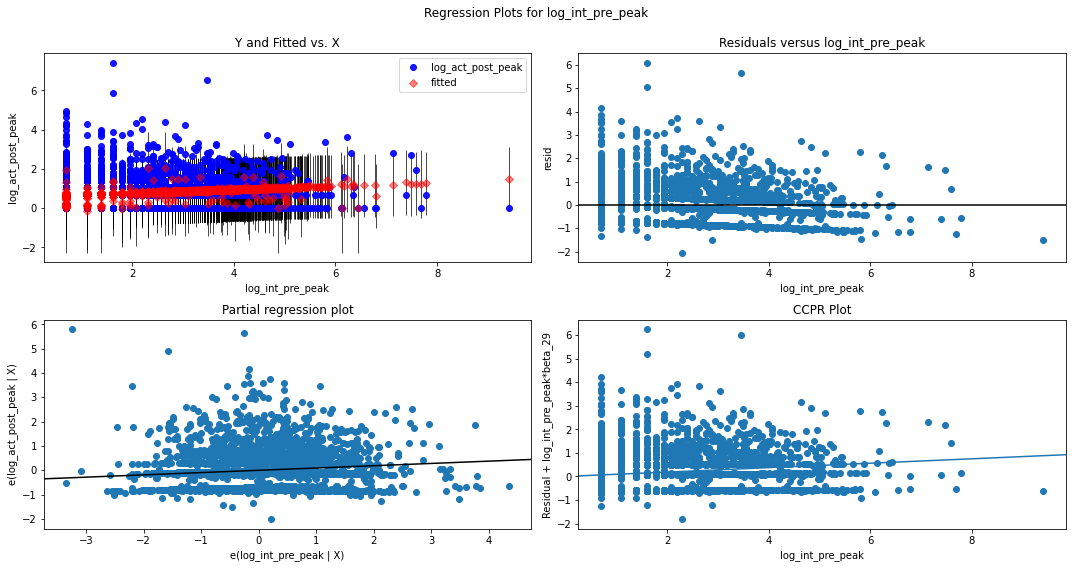

In [33]:
fig = plt.figure(figsize =(15,8))
fig = sm.graphics.plot_regress_exog(stats_result_2, 'log_int_pre_peak', fig=fig)

In [34]:
stats_result_2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:      log_act_post_peak   R-squared:                       0.036
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     3.712
Date:                Thu, 02 Dec 2021   Prob (F-statistic):           4.90e-11
Time:                        13:32:30   Log-Likelihood:                -3624.2
No. Observations:                2993   AIC:                             7310.
Df Residuals:                    2962   BIC:                             7497.
Df Model:                          30                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                 0.7415      0.169      4.380      0.000       0.410       1.073
cluster[T.1]             -0.0690      0.497     -0.139      0.890      -1.044       0.906
cluster[T.3]             -0.0826      0.158     -0.521      0.602      -0.393       0.228
cluster[T.4]             -0.4406      0.438     -1.007      0.314      -1.299       0.417
cluster[T.5]             -0.8515      0.599     -1.422      0.155      -2.025       0.322
cluster[T.6]             -0.7795      0.832     -0.937      0.349      -2.411       0.852
cluster[T.7]             -0.7686      0.832     -0.924      0.356      -2.400       0.863
cluster[T.8]             -0.7984      0.833     -0.959      0.338      -2.431       0.835
cluster[T.10]            -0.6447      0.599     -1.077      0.282      -1.819       0.529
cluster[T.11]            -0.6478      0.228     -2.847      0.004      -1.094      -0.202
cluster[T.14]            -0.2890      0.598     -0.483      0.629      -1.462       0.884
cluster[T.15]             0.5505      0.292      1.883      0.060      -0.023       1.124
cluster[T.16]            -0.2314      0.221     -1.048      0.295      -0.664       0.202
cluster[T.17]             0.0101      0.292      0.035      0.972      -0.563       0.583
cluster[T.18]            -0.3397      0.497     -0.683      0.495      -1.315       0.635
cluster[T.19]            -1.1093      0.832     -1.334      0.182      -2.740       0.521
cluster[T.20]            -1.2092      0.832     -1.453      0.146      -2.841       0.423
cluster[T.21]             1.1627      0.497      2.339      0.019       0.188       2.137
cluster[T.22]            -1.2376      0.832     -1.487      0.137      -2.870       0.394
cluster[T.25]            -0.9539      0.598     -1.594      0.111      -2.127       0.219
cluster[T.26]            -0.5538      0.599     -0.925      0.355      -1.728       0.620
cluster[T.27]            -0.5234      0.329     -1.592      0.112      -1.168       0.121
cluster[T.28]            -0.4841      0.497     -0.974      0.330      -1.459       0.491
cluster[T.29]            -0.5886      0.347     -1.698      0.090      -1.268       0.091
cluster[T.31]            -0.7312      0.278     -2.633      0.009      -1.276      -0.187
cluster[T.32]            -0.1035      0.369     -0.280      0.779      -0.827       0.620
cluster[T.33]             0.2601      0.315      0.826      0.409      -0.357       0.877
cluster[T.34]            -0.8431      0.497     -1.696      0.090      -1.818       0.132
log_act_pre_peak         -0.0126      0.013     -0.974      0.330      -0.038       0.013
log_int_pre_peak          0.0940      0.015      6.237      0.000       0.064       0.124
log_norm_act_pre_peak    -0.0040      0.009     -0.422      0.673      -0.023       0.015
=======================

### Stats model 3: Not taking logs because of zero values. Instead try negative binomial

cf. something like https://besjournals.onlinelibrary.wiley.com/doi/full/10.1111/j.2041-210X.2010.00021.x

In [35]:
stats_model_3 = smf.glm('act_post_peak ~ act_pre_peak + int_pre_peak + norm_act_pre_peak + cluster',
    data = stats_df,
    family = sm.families.family.NegativeBinomial(alpha=1.8)
)
stats_result_3 = stats_model_3.fit()

In [36]:
stats_result_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:          act_post_peak   No. Observations:                 2993
Model:                            GLM   Df Residuals:                     2962
Model Family:        NegativeBinomial   Df Model:                           30
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -5998.6
Date:                Thu, 02 Dec 2021   Deviance:                       3425.9
Time:                        13:32:31   Pearson chi2:                 1.07e+04
No. Iterations:                    84   Pseudo R-squ. (CS):             0.2689
Covariance Type:            nonrobust                                         
=====================================================================================
                        coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------
Intercept             2.8739      0.269     10.703      0.000       2.348       3.400
cluster[T.1]         -2.3412      0.920     -2.545      0.011      -4.144      -0.538
cluster[T.3]         -1.9981      0.269     -7.431      0.000      -2.525      -1.471
cluster[T.4]         -2.6558      0.857     -3.098      0.002      -4.336      -0.975
cluster[T.5]        -42.6410   4.75e+07  -8.99e-07      1.000    -9.3e+07     9.3e+07
cluster[T.6]        -43.4952   6.71e+07  -6.48e-07      1.000   -1.32e+08    1.32e+08
cluster[T.7]        -42.7556   6.71e+07  -6.37e-07      1.000   -1.32e+08    1.32e+08
cluster[T.8]        -42.8318   6.71e+07  -6.38e-07      1.000   -1.32e+08    1.32e+08
cluster[T.10]        -3.6953      1.437     -2.572      0.010      -6.511      -0.880
cluster[T.11]        -4.1418      0.536     -7.729      0.000      -5.192      -3.092
cluster[T.14]        -2.9198      1.197     -2.440      0.015      -5.265      -0.574
cluster[T.15]        -1.6116      0.509     -3.164      0.002      -2.610      -0.613
cluster[T.16]        -2.3485      0.395     -5.946      0.000      -3.123      -1.574
cluster[T.17]        -1.8461      0.518     -3.562      0.000      -2.862      -0.830
cluster[T.18]        -2.6388      0.970     -2.719      0.007      -4.541      -0.737
cluster[T.19]       -42.8572   6.71e+07  -6.39e-07      1.000   -1.32e+08    1.32e+08
cluster[T.20]       -42.5826   6.71e+07  -6.35e-07      1.000   -1.32e+08    1.32e+08
cluster[T.21]         0.9528      0.824      1.157      0.247      -0.662       2.567
cluster[T.22]       -42.6676   6.71e+07  -6.36e-07      1.000   -1.32e+08    1.32e+08
cluster[T.25]       -43.1965   4.75e+07   -9.1e-07      1.000    -9.3e+07     9.3e+07
cluster[T.26]        -2.9445      1.218     -2.418      0.016      -5.331      -0.558
cluster[T.27]        -3.4927      0.698     -5.004      0.000      -4.861      -2.125
cluster[T.28]        -3.2471      1.096     -2.963      0.003      -5.395      -1.099
cluster[T.29]        -3.7457      0.816     -4.592      0.000      -5.345      -2.147
cluster[T.31]        -3.0619      0.536     -5.710      0.000      -4.113      -2.011
cluster[T.32]        -1.9630      0.668     -2.937      0.003      -3.273      -0.653
cluster[T.33]        -0.8768      0.540     -1.623      0.105      -1.936       0.182
cluster[T.34]        -3.6410      1.290     -2.822      0.005      -6.169      -1.112
act_pre_peak          0.0034      0.000     13.005      0.000       0.003       0.004
int_pre_peak         -0.0036      0.000     -8.410      0.000      -0.004      -0.003
norm_act_pre_peak -3.821e-05   1.07e-05     -3.572      0.000   -5.92e-05   -1.72e-05
=====================================================================================
"""

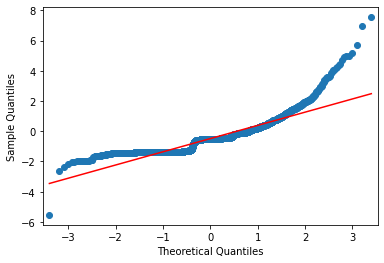

In [37]:
resid = stats_result_3.resid_deviance.copy()
x = sm.graphics.qqplot(resid, line='r')


### Stats model 4: no cluster, negative binomial

In [ ]:
# do I want an intercept?
stats_model_4 = smf.ols('act_post_peak ~ act_pre_peak + int_pre_peak + norm_act_pre_peak',
    data = stats_df
)
stats_result_4 = stats_model_1.fit()

### Further features:

Revisiting Chabot (2010):

![Diffusion](diffusion.png)

* Awareness is hypothesised by Chabot to be through mass media, for example. Not operationalisable here and not really of interest either.
* Translation is the 'meaningful' dialogue between potential transmitters and receivers. This is the key thing to operationalise and why I wanted clustering in the first place
    * perhaps manual coding of key phrases
    * feature measuring the 
* Experimentation
    * This is extremely difficult to model - how can I infer from tweets whether they are 'testing' something out?
    * Theory needs developing here for internet age - Chabot writes '[experimentation] begins with small-scale direct action campaigns and implies intensive dialogue among adoption pioneers'
        * potential operationalisation - measuring more intense periods of interaction WITHIN a hashtag version before peak
        * but small-scale direct action campaigns are not really operationalisable in this context.
    * or another mechanism is likes on one tweet in one interaction.
* Movement Application -> this is my outcome variable, operationalised as amount of integration into target hashtag version
    * another measure - interval before first tweet in another language?
    * make lots of scatter plots
    * scattermatrix pandas
    * more GLMs

* Over and above all of this, who is an activist?
    * but should we even make that distinction? and is that one for me to make? no
    * maybe it made sense in collective action models to differentiate between those who participate in protests, for example, but doing this online is less clear.
    * That's not to say we can't make meaningful segmentations, though. Could do Verified/not verified (there's literature to suggest that's a meaningful difference), and perhaps
    * **think about separating by organisation**
    * just draw line on activity? threshold. Can vary parameter and check robustness obviously.
    * That would be an honest way to separate the users

Next steps:

* expand measure of activity to not be a simple aggregate of before and after a peak. Perhaps a few days before and a few days after? Segment time into weeks?
    * or some measure of density of interactions
* cluster without hashtags?